In [1]:
# read the data in

import pandas as pd
import numpy as np
import sys

def exit_with_error(message):
    print(f"Error: {message}")
    sys.exit(1)

metadata_fname = "data\\metadata_wide.tsv"
quants_fname = "data\\precursors_wide_normalized.tsv"

metadata = pd.read_csv(metadata_fname, sep='\t', na_values=['na'])
data = pd.read_csv(quants_fname, sep='\t')
data = data.fillna(0)
protein_names = data['protein'].values

print("Metadata shape:", metadata.shape)
print("Data shape:", data.shape)

Metadata shape: (291, 29)
Data shape: (773, 294)


Data shape: (128, 773)
Doses: [  0  10  25  75 100]
Plates: ['Pelt-P01' 'Pelt-P02' 'Pelt-P03']
Dose Rates: ['HDR' 'LDR' 'nan']
Focus Areas: ['FA1' 'FA2']
Sample Types: ['Skin Punch' 'nan']
Box Numbers: ['UW00028' 'UW00029' 'UW00030' 'UW00031' 'UW00032']
trex batches: [17. 18. 19. 20. 22. 23. nan]
['FA2' 'FA2' 'FA1' 'FA2' 'FA2' 'FA1' 'FA2' 'FA2' 'FA2' 'FA2' 'FA1' 'FA2'
 'FA2' 'FA2' 'FA2' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA2' 'FA2' 'FA2' 'FA1'
 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA2' 'FA1' 'FA1' 'FA2' 'FA2' 'FA1' 'FA1'
 'FA2' 'FA1' 'FA2' 'FA1' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA1' 'FA1' 'FA1'
 'FA2' 'FA2' 'FA2' 'FA1' 'FA2' 'FA2' 'FA1' 'FA1' 'FA2' 'FA1' 'FA2' 'FA2'
 'FA2' 'FA1' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA2' 'FA2' 'FA2' 'FA2' 'FA2'
 'FA2' 'FA1' 'FA1' 'FA2' 'FA1' 'FA2' 'FA2' 'FA1' 'FA1' 'FA1' 'FA2' 'FA2'
 'FA2' 'FA2' 'FA1' 'FA2' 'FA1' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA1' 'FA1'
 'FA1' 'FA2' 'FA2' 'FA2' 'FA2' 'FA2' 'FA2' 'FA1' 'FA1' 'FA1' 'FA1' 'FA2'
 'FA2' 'FA1' 'FA2' 'FA2' 'FA2' 'FA1' 'FA2' 'F

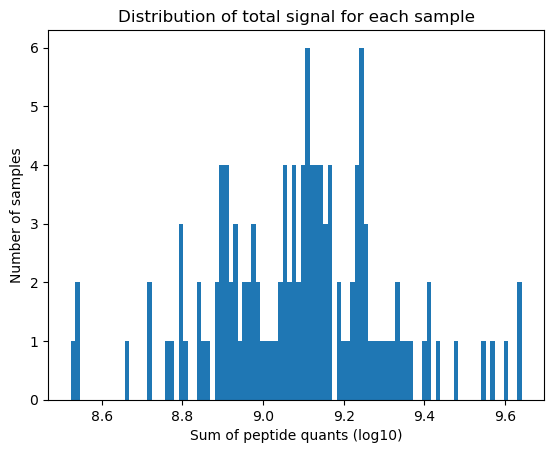

In [2]:
# transform data into what Justin's code is expecting

import matplotlib.pyplot as plt

# valid_replicates = metadata[
#     (metadata['Dose_cGy'].notna()) & 
#     (metadata['Dose_cGy'] != 'pool') &
#     (metadata['Dose_cGy'] != 'blind') &
#     (metadata['Radiation Dose(cGy)'].notna())
# ]['replicate'].tolist()

valid_replicates = metadata[
    (metadata['Dose_cGy'] != 'pool') &
    (metadata['Dose_cGy'] != 'blind') &
    ((metadata.get('Sample Type', '') == 'Skin Punch') | (metadata.get('Sample_Type', '') == 'Skin Punch')) &
    (metadata['Dose_cGy'].notna())
]['replicate'].tolist()


X = []
rad = []
rates = []
plate = []
fa = []
sample_type = []
box_number = []
trex_batch = []

for idx in valid_replicates:
    for sample in data.columns[:]:
        if idx in sample:
            # Get the metadata row for this replicate
            meta_row = metadata[metadata['replicate'] == idx]
            
            s_rad = meta_row['Dose_cGy'].values[0]
            s_rate = meta_row['Dose Rate'].values[0]
            s_plate = meta_row['Plate'].values[0]
            s_fa = meta_row['Focus Area'].values[0]
            if s_fa == '' or s_fa == 'na' or pd.isna(s_fa):
                s_fa = meta_row['Focus_Area'].values[0]

            s_sample_type = meta_row['Sample_Type'].values[0]
            s_box_number = meta_row['TnE_Box_number'].values[0]
            s_trex_batch = meta_row['TnE Sample Batch'].values[0]
            
            # Convert to int only if it's not NA
            rad.append(int(s_rad) if not pd.isna(s_rad) else s_rad)
            rates.append(s_rate)
            plate.append(s_plate)
            fa.append(s_fa)
            sample_type.append(s_sample_type)
            box_number.append(s_box_number)
            trex_batch.append(s_trex_batch)
            X.append(data[sample].values)

X = np.array(X)
rad = np.array(rad)
rates = np.array(rates)
plate = np.array(plate)
fa = np.array(fa)
sample_type = np.array(sample_type)
box_number = np.array(box_number)
trex_batch = np.array(trex_batch)

print("Data shape:", X.shape)
print("Doses:", np.unique(rad))
print("Plates:", np.unique(plate))
print("Dose Rates:", np.unique(rates))
print("Focus Areas:", np.unique(fa))
print("Sample Types:", np.unique(sample_type))
print("Box Numbers:", np.unique(box_number))
print("trex batches:", np.unique(trex_batch))

print(fa)
print(trex_batch)
print(rad)
total_signal = np.sum(X, axis=1)
plt.hist(np.log10(total_signal), bins=100)
plt.title('Distribution of total signal for each sample')
plt.ylabel('Number of samples')
plt.xlabel('Sum of peptide quants (log10)')
plt.show()

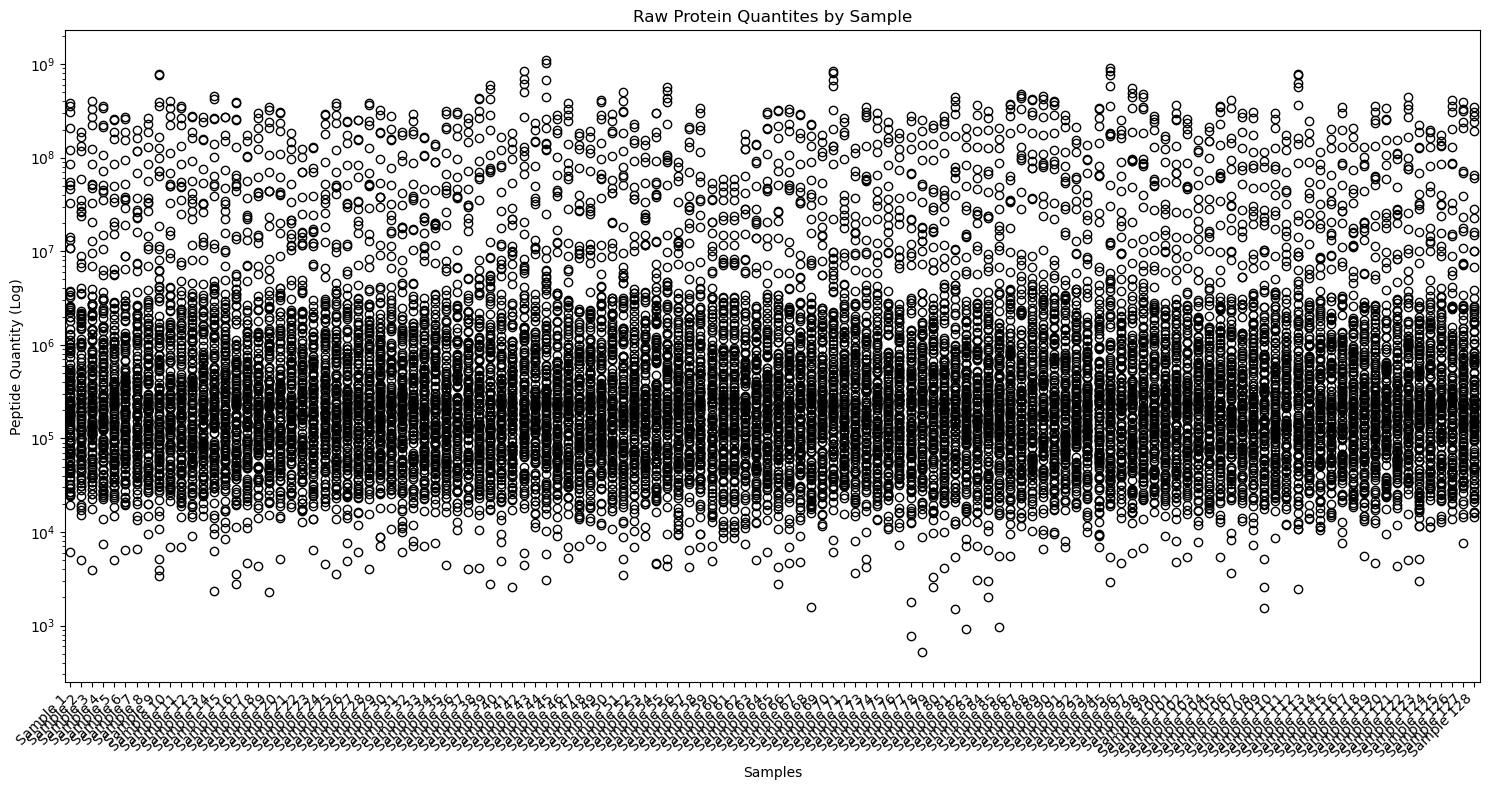

In [3]:
# Create the box plot
plt.figure(figsize=(15, 8))
plt.boxplot(X.T)  # Transpose the data

plt.title('Raw Protein Quantites by Sample')
plt.xlabel('Samples')
plt.ylabel('Peptide Quantity (Log)')
plt.xticks(range(1, X.shape[0] + 1), [f'Sample {i+1}' for i in range(X.shape[0])], rotation=45, ha='right')

# Use log scale for y-axis as peptide quantities often span several orders of magnitude
plt.yscale('log')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [4]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import median_abs_deviation

# mad = median_abs_deviation(X, axis=0)
# mad_series = pd.Series(mad, name='Median Absolute Deviation')
# mean_mad = np.mean(mad)

# # Plot the probability density
# plt.figure(figsize=(12, 7))
# sns.kdeplot(data=mad_series, shade=True)

# plt.title('Probability Density of Protein Variation\nNew Data Data, Carafe Search', fontsize=16)
# plt.xlabel('Median Absolute Deviation', fontsize=14)
# plt.ylabel('Density', fontsize=14)

# plt.xlim(-0.1, 2.2)
# plt.xticks(np.arange(-0.1, 2.3, 0.1))

# plt.axvline(mean_mad, color='red', linestyle='--', linewidth=2)

# plt.text(mean_mad, plt.ylim()[1], f'Mean: {mean_mad:.3f}', 
#          horizontalalignment='center', verticalalignment='bottom',
#          color='red', fontweight='bold', fontsize=12)

# plt.tight_layout()
# plt.show()

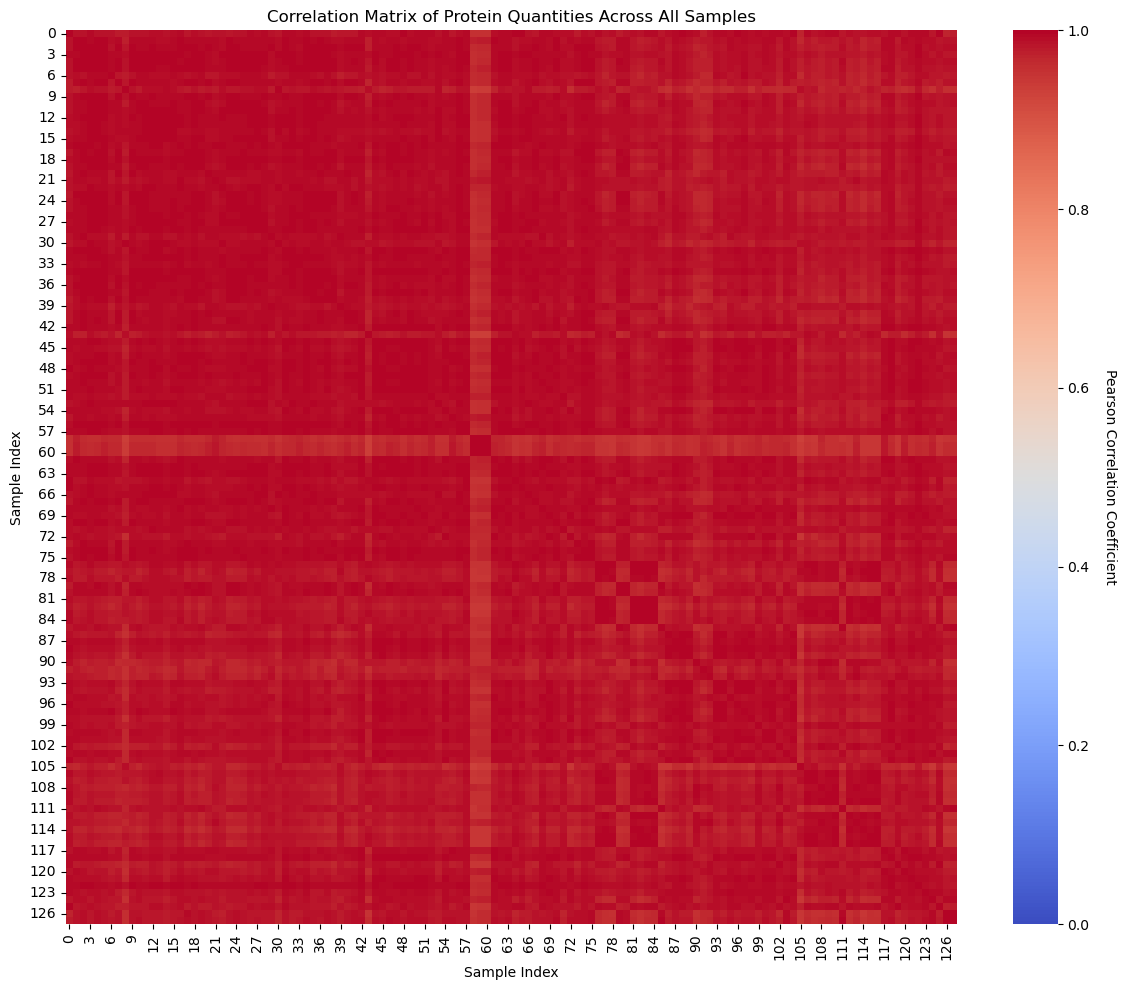

Number of samples: 128
Number of proteins: 773
Using unlogged values
Average correlation (excluding self-correlations): 0.9864


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def plot_protein_correlation_matrix(unlogged_X, use_log=True, save_path=None):
    """
    Create a correlation matrix heatmap comparing protein quantities across all samples.
    
    Parameters:
    unlogged_X (np.array): 2D array with samples as rows, proteins as columns, and quantities as values
    use_log (bool, optional): Whether to use log-transformed values for protein quantities. Defaults to True.
    save_path (str, optional): Path to save the plot. If None, the plot will be displayed instead.
    
    Returns:
    np.array: The correlation matrix
    """
    
    # Apply log transformation if use_log is True
    tmpX = np.log2(unlogged_X) if use_log else unlogged_X
    
    # Compute the correlation matrix
    corr_matrix = np.corrcoef(tmpX)
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0.5, vmin=0, vmax=1)
    
    plt.title('Correlation Matrix of Protein Quantities Across All Samples')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    
    # Add colorbar label
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel('Pearson Correlation Coefficient', rotation=270, labelpad=20)
    
    plt.tight_layout()
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()
    
    # Print summary statistics
    print(f"Number of samples: {tmpX.shape[0]}")
    print(f"Number of proteins: {tmpX.shape[1]}")
    print(f"Using {'log-transformed' if use_log else 'unlogged'} values")
    
    # Calculate and print the average correlation, excluding self-correlations
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    upper_triangle = corr_matrix[mask]
    average_correlation = np.mean(upper_triangle)
    print(f"Average correlation (excluding self-correlations): {average_correlation:.4f}")
    
    return corr_matrix

corr_matrix = plot_protein_correlation_matrix(X, use_log=False)

In [6]:
# features = pd.read_csv(targets_fname, sep='\t')
# idxs = []
# for idx,protein in enumerate(protein_names):
#   f = features[features['Protein'] == protein]
#   if len(f) > 0:
#     idxs.append(idx)
# print(len(idxs))
# top_protein_names = protein_names[idxs]
# s_idxs = np.argsort(top_protein_names)
# sorted_names = top_protein_names[s_idxs]
# idxs = np.array(idxs)[s_idxs]

In [7]:
# # Create the box plot
# plt.figure(figsize=(15, 8))
# plt.boxplot(X[:,idxs].T)  # Transpose the data

# plt.title('Raw Protein Quantites by Sample (Targets)')
# plt.xlabel('Samples')
# plt.ylabel('Peptide Quantity (Log)')
# plt.xticks(range(1, X.shape[0] + 1), [f'Sample {i+1}' for i in range(X.shape[0])], rotation=45, ha='right')

# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.show()

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from matplotlib.colors import ListedColormap

# # Assume your data:
# # X: 2D NumPy array (samples x proteins)
# # labels: 1D NumPy array (categorical labels for each sample)

# # Create mask for filtering
# mask = [(f == 'FA1') for r, t, f, s, b in zip(rad, rates, fa, sample_type, trex_batch)]
# print(trex_batch)
# filtered_labels = trex_batch[mask]
# print(filtered_labels)
# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X[mask])

# # Perform PCA with 4 components to capture PC3 and PC4
# pca = PCA(n_components=4)
# X_pca = pca.fit_transform(X_scaled)

# # Explained variance ratios
# explained_var = pca.explained_variance_ratio_ * 100  # Convert to percentage

# # Assign unique colors to categorical labels
# unique_labels = np.unique(filtered_labels)
# label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
# colors = [label_to_color[label] for label in filtered_labels]

# # Use a high-contrast colormap
# cmap = ListedColormap(plt.cm.tab10.colors[:len(unique_labels)])

# # Create PCA plots with white background
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# for ax in axes:
#     ax.set_facecolor('white')  # Ensure no grey background

# # PC1 vs PC2 plot
# scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap=cmap, edgecolor='k', alpha=0.8)
# axes[0].set_xlabel(f"PC1 ({explained_var[0]:.1f}% variance)")
# axes[0].set_ylabel(f"PC2 ({explained_var[1]:.1f}% variance)")
# axes[0].set_title("PCA of Protein Quantities (PC1 vs PC2)")

# # Create legend for PC1 vs PC2 plot
# handles = [plt.Line2D([0], [0], marker='o', linestyle='', markersize=8, markerfacecolor=cmap(idx), markeredgecolor='k') 
#            for idx in range(len(unique_labels))]

# # PC3 vs PC4 plot
# scatter2 = axes[1].scatter(X_pca[:, 2], X_pca[:, 3], c=colors, cmap=cmap, edgecolor='k', alpha=0.8)
# axes[1].set_xlabel(f"PC3 ({explained_var[2]:.1f}% variance)")
# axes[1].set_ylabel(f"PC4 ({explained_var[3]:.1f}% variance)")
# axes[1].set_title("PCA of Protein Quantities (PC3 vs PC4)")
# axes[1].legend(handles, unique_labels, title="Sample Labels", loc="upper right", frameon=True)

# plt.tight_layout()
# plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict, Union
import warnings

def crossvalidate_binary_logistic(
    labeled_X: np.ndarray, 
    y: np.ndarray, 
    param: Dict[str, Union[str, float, int]],
    title: str = "Logistic Regression ROC Curve",
    random_state: int = 1966
) -> Tuple[List[float], List[float], np.ndarray]:
    """
    Perform repeated k-fold cross-validation for binary logistic regression with regularization.
    Features are standardized within each fold to prevent data leakage.
    
    Args:
        labeled_X: Feature matrix
        y: Target vector
        param: Dictionary of parameters for LogisticRegression
        title: Plot title
        random_state: Random seed for reproducibility
                       
    Returns:
        Tuple of:
            - List of training accuracies (percent)
            - List of test accuracies (percent)
            - Numpy array of summed coefficients for each feature across all folds
    """
    print("Baseline Accuracy:", sum(y)/len(y))
    
    # Set default parameters if not provided
    default_params = {
        'C': 1.0,
        'penalty': 'elasticnet',
        'l1_ratio': 0.5,
        'solver': 'saga',
        'max_iter': 5000,
        'random_state': random_state,
        'warm_start': True,
        'tol': 1e-4,
    }
    
    # Update defaults with provided parameters
    model_params = {**default_params, **param}
    
    # Keep track of convergence
    convergence_failures = 0
    total_folds = 50  # 10 splits * 5 repeats = 50 total folds
    
    # Convert inputs to numpy arrays if they aren't already
    labeled_X = np.array(labeled_X)
    y = np.array(y)
    
    # Create figures for ROC curve
    fig, ax = plt.subplots(figsize=(6, 6))
    _, garbage_ax = plt.subplots(figsize=(6, 6))  # Temporary figure for individual curves
    
    # Initialize lists to store results
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 1000)
    train_accs = []
    test_accs = []
    
    # To accumulate coefficients
    coef_sums = np.zeros(labeled_X.shape[1])
    
    # Set up cross-validation
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)
    
    # Suppress the specific convergence warning
    with warnings.catch_warnings(record=True) as w:
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        
        # Perform cross-validation
        for train, test in skf.split(labeled_X, y):
            X_train, X_test = labeled_X[train], labeled_X[test]
            y_train, y_test = y[train], y[test]
            
            # Scale features using only training data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Initialize and train logistic regression model
            model = LogisticRegression(**model_params)
            model.fit(X_train_scaled, y_train)
            
            # Check convergence
            if not model.n_iter_ < model_params['max_iter']:
                convergence_failures += 1
            
            # Get predictions and probabilities
            train_pred = model.predict(X_train_scaled)
            test_pred = model.predict(X_test_scaled)
            test_prob = model.predict_proba(X_test_scaled)[:, 1]
            
            # Calculate accuracies
            train_acc = accuracy_score(y_train, train_pred)
            test_acc = accuracy_score(y_test, test_pred)
            train_accs.append(train_acc * 100)
            test_accs.append(test_acc * 100)
            
            # Add coefficients from this fold to the sum
            coef_sums += model.coef_[0]
            
            # Calculate ROC curve on temporary axis
            viz = RocCurveDisplay.from_predictions(
                y_test,
                test_prob,
                ax=garbage_ax
            )
            
            # Interpolate TPR
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
            
            # Clear the temporary plot
            garbage_ax.clear()
    
    # Report convergence status
    if convergence_failures > 0:
        print(f"\nWarning: {convergence_failures}/{total_folds} folds did not achieve convergence.")
        print("Consider one or more of these solutions:")
        print(f"1. Increase max_iter (currently {model_params['max_iter']})")
        print(f"2. Increase tol (currently {model_params['tol']})")
        print(f"3. Decrease C (currently {model_params['C']}) to reduce model complexity")
        print()
    
    # Plot styling
    plt.style.use('ggplot')
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
    
    # Calculate and plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
        lw=2,
        alpha=0.8,
    )
    
    # Add standard deviation band
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label="±1 std. dev.",
    )
    
    # Configure plot
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title
    )
    ax.axis("square")
    
    # Clean up legend
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[-2:]
    labels = labels[-2:]
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="lower right")
    
    # Remove the temporary figure
    plt.close(garbage_ax.figure)
    
    plt.show()
    
    print(f"Average Train Accuracy: {np.mean(train_accs):.2f}% ± {np.std(train_accs):.2f}%")
    print(f"Average Test Accuracy: {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    
    return train_accs, test_accs, coef_sums

In [10]:
def crossvalidate_binary_logistic_enforced_hierarchy(
   labeled_X: np.ndarray, 
   y: np.ndarray, 
   param: Dict[str, Union[str, float, int]],
   feature_names: np.ndarray,  # Add feature names as parameter
   title: str = "Logistic Regression ROC Curve",
   random_state: int = 1966
) -> Tuple[List[float], List[float], np.ndarray]:
   """
   Perform repeated k-fold cross-validation for binary logistic regression with regularization.
   Features are standardized within each fold to prevent data leakage.
   Enforces hierarchy principle - if interaction terms survive regularization, their parent terms
   are included in the model even if they would have been regularized away.
   
   Args:
       labeled_X: Feature matrix
       y: Target vector
       param: Dictionary of parameters for LogisticRegression
       feature_names: Names of features in labeled_X
       title: Plot title
       random_state: Random seed for reproducibility
                      
   Returns:
       Tuple of:
           - List of training accuracies (percent)
           - List of test accuracies (percent)
           - Numpy array of summed coefficients for each feature across all folds
   """
   print("Baseline Accuracy:", sum(y)/len(y))
   
   # Set default parameters if not provided
   default_params = {
       'C': 1.0,
       'penalty': 'elasticnet',
       'l1_ratio': 0.5,
       'solver': 'saga',
       'max_iter': 5000,
       'random_state': random_state,
       'warm_start': True,
       'tol': 1e-4,
   }
   
   # Update defaults with provided parameters
   model_params = {**default_params, **param}
   
   # Keep track of convergence
   convergence_failures = 0
   total_folds = 50  # 10 splits * 5 repeats = 50 total folds
   
   # Convert inputs to numpy arrays if they aren't already
   labeled_X = np.array(labeled_X)
   y = np.array(y)
   
   # Create figures for ROC curve
   fig, ax = plt.subplots(figsize=(6, 6))
   _, garbage_ax = plt.subplots(figsize=(6, 6)) 
   
   # Initialize lists to store results
   tprs = []
   aucs = []
   mean_fpr = np.linspace(0, 1, 1000)
   train_accs = []
   test_accs = []
   
   # To accumulate coefficients
   coef_sums = np.zeros(labeled_X.shape[1])
   
   def get_parent_terms(interaction_features):
       """Helper function to get parent terms of interactions"""
       parent_terms = set()
       for feature in interaction_features:
           if '_TSE_' in feature:
               # Get both parts of the interaction
               parts = feature.split('_TSE_')
               parent_terms.add(parts[0])  # Original feature
               parent_terms.add(f'TSE_{parts[1]}')  # TSE term
       return parent_terms
   
   # Set up cross-validation
   skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)
   
   # Suppress the specific convergence warning
   with warnings.catch_warnings(record=True) as w:
       warnings.filterwarnings('ignore', category=ConvergenceWarning)
       
       # Perform cross-validation
       for train, test in skf.split(labeled_X, y):
           X_train, X_test = labeled_X[train], labeled_X[test]
           y_train, y_test = y[train], y[test]
           
           # Scale features using only training data
           scaler = StandardScaler()
           X_train_scaled = scaler.fit_transform(X_train)
           X_test_scaled = scaler.transform(X_test)
           
           # Two-stage fitting process:
           # 1. First fit to identify important interactions
           model = LogisticRegression(**model_params)
           model.fit(X_train_scaled, y_train)
           
           # Find features with non-zero coefficients
           nonzero_features = [name for name, coef in zip(feature_names, model.coef_[0]) 
                              if abs(coef) > 1e-5]  # Small threshold for numerical stability
           
           # Get parent terms of surviving interactions
           parent_terms = get_parent_terms(nonzero_features)
           
           # Create mask for features to keep (including parents)
           features_to_keep = list(set(nonzero_features) | parent_terms)
           feature_mask = np.array([name in features_to_keep for name in feature_names])
           
           # 2. Refit with enforced hierarchy
           X_train_masked = X_train_scaled[:, feature_mask]
           X_test_masked = X_test_scaled[:, feature_mask]
           
           model = LogisticRegression(**model_params)
           model.fit(X_train_masked, y_train)
           
           # Update coefficient sums (pad with zeros for excluded features)
           temp_coefs = np.zeros(labeled_X.shape[1])
           temp_coefs[feature_mask] = model.coef_[0]
           coef_sums += temp_coefs
           
           # Check convergence
           if not model.n_iter_ < model_params['max_iter']:
               convergence_failures += 1
           
           # Get predictions and probabilities
           train_pred = model.predict(X_train_masked)
           test_pred = model.predict(X_test_masked)
           test_prob = model.predict_proba(X_test_masked)[:, 1]
           
           # Calculate accuracies
           train_acc = accuracy_score(y_train, train_pred)
           test_acc = accuracy_score(y_test, test_pred)
           train_accs.append(train_acc * 100)
           test_accs.append(test_acc * 100)
           
           # Calculate ROC curve on temporary axis
           viz = RocCurveDisplay.from_predictions(
               y_test,
               test_prob,
               ax=garbage_ax
           )
           
           # Interpolate TPR
           interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
           interp_tpr[0] = 0.0
           tprs.append(interp_tpr)
           aucs.append(viz.roc_auc)
           
           # Clear the temporary plot
           garbage_ax.clear()
   
   # Report convergence status
   if convergence_failures > 0:
       print(f"\nWarning: {convergence_failures}/{total_folds} folds did not achieve convergence.")
       print("Consider one or more of these solutions:")
       print(f"1. Increase max_iter (currently {model_params['max_iter']})")
       print(f"2. Increase tol (currently {model_params['tol']})")
       print(f"3. Decrease C (currently {model_params['C']}) to reduce model complexity")
       print()
   
   # Plot styling
   plt.style.use('ggplot')
   plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
   
   # Calculate and plot mean ROC curve
   mean_tpr = np.mean(tprs, axis=0)
   mean_tpr[-1] = 1.0
   mean_auc = auc(mean_fpr, mean_tpr)
   std_auc = np.std(aucs)
   
   ax.plot(
       mean_fpr,
       mean_tpr,
       color="b",
       label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
       lw=2,
       alpha=0.8,
   )
   
   # Add standard deviation band
   std_tpr = np.std(tprs, axis=0)
   tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
   tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
   ax.fill_between(
       mean_fpr,
       tprs_lower,
       tprs_upper,
       color="grey",
       alpha=0.2,
       label="±1 std. dev.",
   )
   
   # Configure plot
   ax.set(
       xlim=[-0.05, 1.05],
       ylim=[-0.05, 1.05],
       xlabel="False Positive Rate",
       ylabel="True Positive Rate",
       title=title
   )
   ax.axis("square")
   
   # Clean up legend
   handles, labels = ax.get_legend_handles_labels()
   handles = handles[-2:]
   labels = labels[-2:]
   by_label = dict(zip(labels, handles))
   ax.legend(by_label.values(), by_label.keys(), loc="lower right")
   
   # Remove the temporary figure
   plt.close(garbage_ax.figure)
   
   plt.show()
   
   print(f"Average Train Accuracy: {np.mean(train_accs):.2f}% ± {np.std(train_accs):.2f}%")
   print(f"Average Test Accuracy: {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
   
   return train_accs, test_accs, coef_sums

[ 75   0  10  75  75  75   0   0  25  75  10  75  75  10  10  10   0  25
  75  75  10  75  10   0  10   0 100  25  75   0   0  75  10  75  10  10
   0  25  10  10  10  10  75 100  75  10  25  75   0   0  75   0  75  75
  75  75  25  10  75  10   0]
[True, False, False, True, True, True, False, False, False, True, False, True, True, False, False, False, False, False, True, True, False, True, False, False, False, False, True, False, True, False, False, True, False, True, False, False, False, False, False, False, False, False, True, True, True, False, False, True, False, False, True, False, True, True, True, True, False, False, True, False, False]
(61, 773) 61 24
Baseline Accuracy: 0.39344262295081966


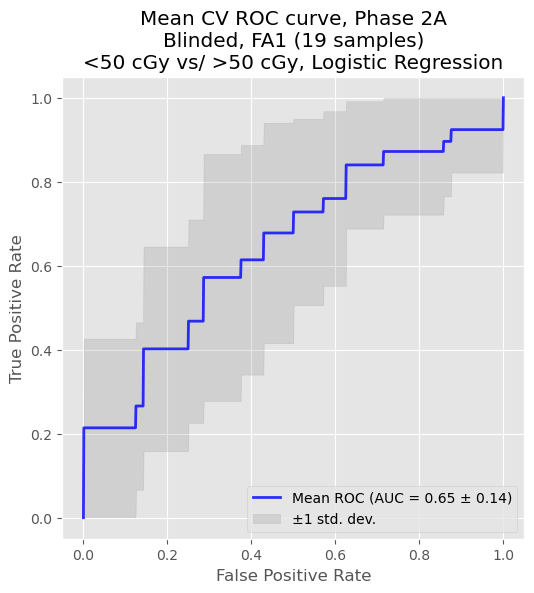

Average Train Accuracy: 93.03% ± 2.84%
Average Test Accuracy: 62.10% ± 11.16%


In [13]:
from sklearn.preprocessing import OneHotEncoder

# FA1 batches: 17 19 22 23
# FA2 batches: 18 20

# Time since exposure (days): [  6.   7.  14.  20.  21.  90.  91. 119. 120. 148. 150.  nan]

# Create a combined mask for both conditions
mask = [(f == 'FA1') for r, t, f, s, b in zip(rad, rates, fa, sample_type, trex_batch)]

# Apply the mask to your arrays
X_targets = X[mask]
y = rad[mask]
print(y)
y = [r > 50 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .5,
    'penalty': 'elasticnet',
    'l1_ratio': 1,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nBlinded, FA1 (19 samples)\n<50 cGy vs/ >50 cGy, Logistic Regression"
)


X_targets shape (350, 89)
X_targets shape (350, 180)
sorted_names length 89
aug_sorted_names length 180
Unique mapped times: [ 6 20]
TSE encoded shape: (350, 1)
Interaction terms shape: (350, 90)
TSE feature names: ['TSE_20']
Number of interaction names: 90
0: 96
9: 54
10: 42
23: 35
24: 19
70: 14
71: 18
72: 12
73: 10
75: 42
100: 8
[True, False, True, False, False, False, False, False, True, False, True, True, True, False, False, True, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, True, False, False, True, False, False, False, False, False, False, True, False, False, True, False, False, False, False, True, False, True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, True, False, False, True, True, False, False, True, False, False, False, False, True, False, False, True, False, True, False, False, True, False, True, False, True, False, Fals

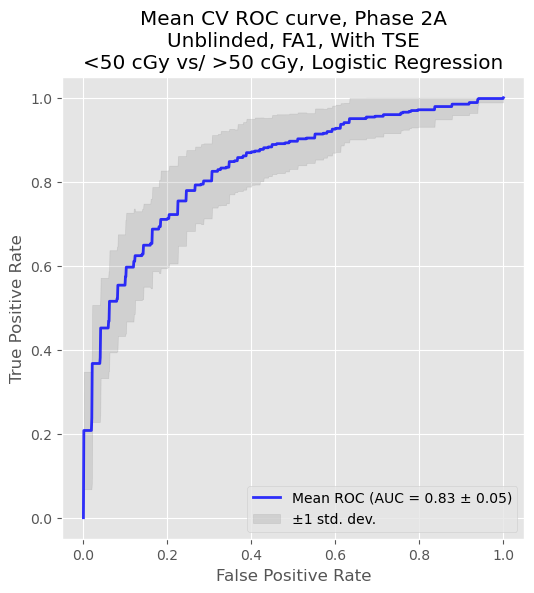

Average Train Accuracy: 90.70% ± 1.17%
Average Test Accuracy: 80.40% ± 4.56%


In [45]:
from sklearn.preprocessing import OneHotEncoder

# FA1 batches: 17 19 22 23
# FA2 batches: 18 20

# Time since exposure (days): [  6.   7.  14.  20.  21.  90.  91. 119. 120. 148. 150.  nan]

# Create a combined mask for both conditions
mask = [(f == 'FA1' and b in [17, 19, 22, 23]) for r, t, f, s, b, tse in zip(rad, rates, fa, sample_type, trex_batch, time_since_exposure)]

# Apply the mask to your arrays
X_targets = X[mask][:,idxs]

# # add plate as a feature:
# plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
# plate_encoded = encoder.fit_transform(plate_filtered)
# X_targets = np.hstack((X_targets, plate_encoded))

# # add box number as a feature:
# box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
# box_encoded = encoder.fit_transform(box_filtered)
# X_targets = np.hstack((X_targets, box_encoded))

# # add batch as a feature:
# batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
# batch_encoded = encoder.fit_transform(batch_filtered)
# X_targets = np.hstack((X_targets, batch_encoded))

# # add interaction terms with batch
# original_features = X[mask][:, idxs]  # Only features from X[mask]
# interaction_terms = original_features[:, :, None] * batch_encoded[:, None, :]  # Outer product
# interaction_terms = interaction_terms.reshape(X_targets.shape[0], -1)
# X_targets = np.hstack((X_targets, interaction_terms))

# # add radiation date as a feature:
# rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
# rad_date_encoded = encoder.fit_transform(rad_date_filtered)
# X_targets = np.hstack((X_targets, rad_date_encoded))

# add time since exposure as a feature:

print("X_targets shape", X_targets.shape)

time_mapping = {
    6: 6,
    7: 6,   # Map 7 to 6
    14: 20,
    20: 20,
    21: 20  # Map 21 to 20
}

aug_sorted_names = sorted_names

tse_mapped = np.array([time_mapping.get(x, x) for x in time_since_exposure[mask]])
tse_filtered = tse_mapped.reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
tse_encoded = encoder.fit_transform(tse_filtered)

# Get the unique time values after mapping (sorted) for creating labels
unique_times = np.sort(np.unique(tse_mapped))
# Create TSE feature names (excluding the first category due to drop='first')
tse_feature_names = np.array([f'TSE_{t}' for t in unique_times[1:]])
aug_sorted_names = np.concatenate((aug_sorted_names, tse_feature_names))

X_targets = np.hstack((X_targets, tse_encoded))

# Create interaction term feature names using the FULL set of features before interactions
n_features_before_interactions = X_targets.shape[1]  # This now includes both original features and TSE features
full_features = aug_sorted_names  # This includes both original features and TSE features
interaction_names = np.array([f'{orig}_{tse}' for orig in full_features for tse in tse_feature_names])
aug_sorted_names = np.concatenate((aug_sorted_names, interaction_names))

# add interaction terms with time since exposure
interaction_terms = X_targets[:, :, None] * tse_encoded[:, None, :]  # Outer product
interaction_terms = interaction_terms.reshape(X_targets.shape[0], -1)
X_targets = np.hstack((X_targets, interaction_terms))

print("X_targets shape", X_targets.shape)
print("sorted_names length", len(sorted_names))
print("aug_sorted_names length", len(aug_sorted_names))

# After mapping
print("Unique mapped times:", np.unique(tse_mapped))

# After encoding
print("TSE encoded shape:", tse_encoded.shape)

# After creating interaction terms
print("Interaction terms shape:", interaction_terms.shape)

# Check feature names
print("TSE feature names:", tse_feature_names)
print("Number of interaction names:", len(interaction_names))

y = rad[mask]

# modify values for batch 22
# batch_selected = np.array(trex_batch)[mask]
# y[batch_selected == 22] = 0


unique_values, counts = np.unique(y, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

y = [r > 50 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .6,
    'penalty': 'elasticnet',
    'l1_ratio': 1,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA1, With TSE\n<50 cGy vs/ >50 cGy, Logistic Regression"
)


X_targets shape (350, 89)
X_targets shape (350, 180)
sorted_names length 89
aug_sorted_names length 180
Unique mapped times: [ 6 20]
TSE encoded shape: (350, 1)
Interaction terms shape: (350, 90)
TSE feature names: ['TSE_20']
Number of interaction names: 90
0: 96
9: 54
10: 42
23: 35
24: 19
70: 14
71: 18
72: 12
73: 10
75: 42
100: 8
[True, False, True, False, False, False, False, False, True, False, True, True, True, False, False, True, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, True, False, False, True, False, False, False, False, False, False, True, False, False, True, False, False, False, False, True, False, True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, True, False, False, True, True, False, False, True, False, False, False, False, True, False, False, True, False, True, False, False, True, False, True, False, True, False, Fals

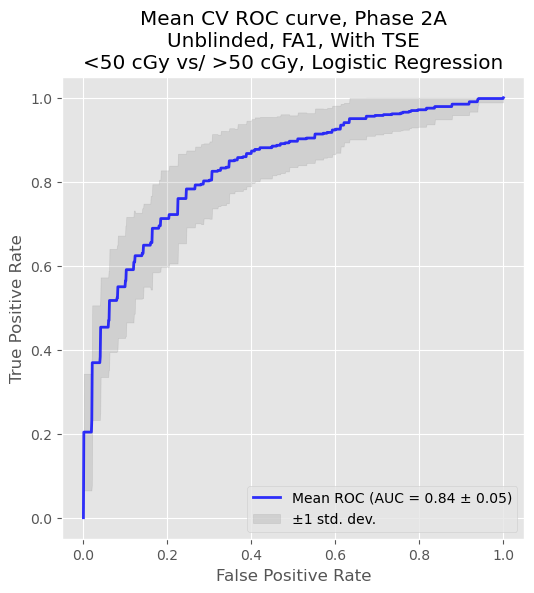

Average Train Accuracy: 90.71% ± 1.15%
Average Test Accuracy: 80.46% ± 4.40%


In [50]:
from sklearn.preprocessing import OneHotEncoder

# FA1 batches: 17 19 22 23
# FA2 batches: 18 20

# Time since exposure (days): [  6.   7.  14.  20.  21.  90.  91. 119. 120. 148. 150.  nan]

# Create a combined mask for both conditions
mask = [(f == 'FA1' and b in [17,19,22,23]) for r, t, f, s, b, tse in zip(rad, rates, fa, sample_type, trex_batch, time_since_exposure)]

# Apply the mask to your arrays
X_targets = X[mask][:,idxs]

# add time since exposure as a feature:

print("X_targets shape", X_targets.shape)

time_mapping = {
    6: 6,
    7: 6,   # Map 7 to 6
    14: 20,
    20: 20,
    21: 20  # Map 21 to 20
}

aug_sorted_names = sorted_names

tse_mapped = np.array([time_mapping.get(x, x) for x in time_since_exposure[mask]])
tse_filtered = tse_mapped.reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
tse_encoded = encoder.fit_transform(tse_filtered)

# Get the unique time values after mapping (sorted) for creating labels
unique_times = np.sort(np.unique(tse_mapped))
# Create TSE feature names (excluding the first category due to drop='first')
tse_feature_names = np.array([f'TSE_{t}' for t in unique_times[1:]])
aug_sorted_names = np.concatenate((aug_sorted_names, tse_feature_names))

X_targets = np.hstack((X_targets, tse_encoded))

# Create interaction term feature names using the FULL set of features before interactions
n_features_before_interactions = X_targets.shape[1]  # This now includes both original features and TSE features
full_features = aug_sorted_names  # This includes both original features and TSE features
interaction_names = np.array([f'{orig}_{tse}' for orig in full_features for tse in tse_feature_names])
aug_sorted_names = np.concatenate((aug_sorted_names, interaction_names))

# add interaction terms with time since exposure
interaction_terms = X_targets[:, :, None] * tse_encoded[:, None, :]  # Outer product
interaction_terms = interaction_terms.reshape(X_targets.shape[0], -1)
X_targets = np.hstack((X_targets, interaction_terms))

print("X_targets shape", X_targets.shape)
print("sorted_names length", len(sorted_names))
print("aug_sorted_names length", len(aug_sorted_names))

# After mapping
print("Unique mapped times:", np.unique(tse_mapped))

# After encoding
print("TSE encoded shape:", tse_encoded.shape)

# After creating interaction terms
print("Interaction terms shape:", interaction_terms.shape)

# Check feature names
print("TSE feature names:", tse_feature_names)
print("Number of interaction names:", len(interaction_names))

y = rad[mask]

# modify values for batch 22
# batch_selected = np.array(trex_batch)[mask]
# y[batch_selected == 22] = 0


unique_values, counts = np.unique(y, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

y = [r > 50 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .6,
    'penalty': 'elasticnet',
    'l1_ratio': 1,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic_enforced_hierarchy(
    labeled_X=X_targets,
    y=y,
    param=param,
    feature_names=aug_sorted_names,
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA1, With TSE\n<50 cGy vs/ >50 cGy, Logistic Regression"
)


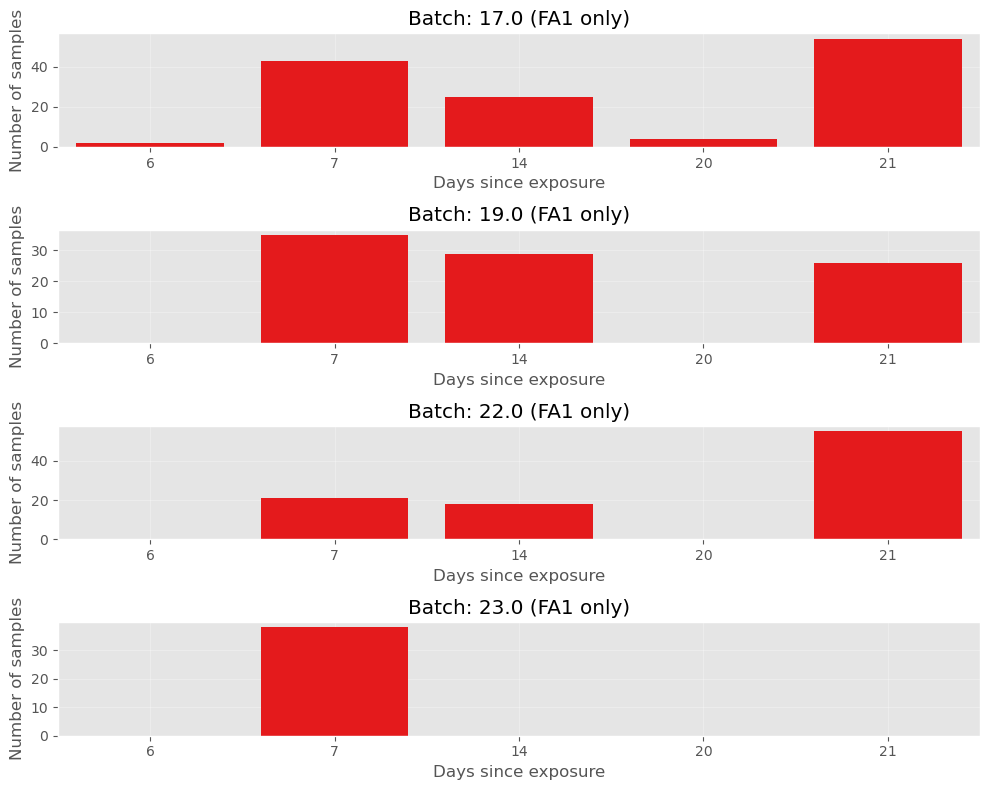

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Create mask for FA1 samples
fa1_mask = fa == 'FA1'

# Get unique batches for FA1 samples only
unique_batches = np.unique(trex_batch[fa1_mask])

# Get all unique time points across all batches (for consistent x-axis)
all_times = np.unique(time_since_exposure[fa1_mask & ~np.isnan(time_since_exposure)])
all_times = np.sort(all_times)  # Sort times for consistent ordering

# Create figure with enough height to accommodate all batches clearly
plt.figure(figsize=(10, max(8, len(unique_batches)*2)))

# For each batch, count samples at each time point
for i, batch in enumerate(unique_batches):
    # Get time points for this batch AND FA1
    batch_mask = (trex_batch == batch) & fa1_mask
    batch_times = time_since_exposure[batch_mask]
    
    # Count occurrences of each unique time point
    counts = [np.sum((batch_times == time)) for time in all_times]
    
    # Create subplot for this batch
    plt.subplot(len(unique_batches), 1, i+1)
    plt.bar(range(len(all_times)), counts)
    
    # Set x-ticks to be the time points
    plt.xticks(range(len(all_times)), all_times.astype(int))
    
    plt.title(f'Batch: {batch} (FA1 only)')
    plt.xlabel('Days since exposure')
    plt.ylabel('Number of samples')
    plt.grid(True, alpha=0.3)
    
    # Set consistent x-axis limits for all plots
    plt.xlim(-0.5, len(all_times) - 0.5)

plt.tight_layout()
plt.show()

In [18]:
protein_coef_dict = {name: coef for name, coef in zip(aug_sorted_names, coef_sums)}
# Sort by the absolute value of the coefficient sums
sorted_proteins = sorted(protein_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)
# Print the top proteins
for name, coef_sum in sorted_proteins[:1000]:
    print(f"{name}: {coef_sum:.4f}")

sp|Q9D379|HYEP_MOUSE: 39.8863
sp|P04441|HG2A_MOUSE: -29.2510
sp|Q8VBX4|CLC4K_MOUSE: -13.1731
sp|Q9DBS1|TMM43_MOUSE: 12.3263
sp|Q61878|PRG2_MOUSE: -12.3174
sp|P10810|CD14_MOUSE: -10.1803
sp|O89053|COR1A_MOUSE_TSE_20: -9.5708
sp|P17427|AP2A2_MOUSE: -9.2740
sp|Q91X52|DCXR_MOUSE: 9.2501
sp|P13864|DNMT1_MOUSE_TSE_20: -9.2067
sp|Q9Z2A9|GGT5_MOUSE: 8.8946
sp|P06800|PTPRC_MOUSE: 7.9770
sp|Q8BH86|GLUCM_MOUSE: 6.7626
sp|Q80X19|COEA1_MOUSE: 5.0323
sp|P04117|FABP4_MOUSE: 4.8825
sp|P06344|HB2U_MOUSE: -4.8272
sp|Q9CZE3|RAB32_MOUSE: 3.7483
sp|P57016|LAD1_MOUSE: 3.3427
sp|P35762|CD81_MOUSE: -2.2945
sp|P97311|MCM6_MOUSE_TSE_20: -2.2902
sp|P54227|STMN1_MOUSE: 2.2315
sp|Q9CWK8|SNX2_MOUSE: 2.1856
sp|Q61753|SERA_MOUSE_TSE_20: -2.0635
sp|Q8R0W0|EPIPL_MOUSE_TSE_20: 2.0300
sp|Q9WV95|PHLA3_MOUSE: 1.9891
sp|Q8R550|SH3K1_MOUSE: -1.9660
sp|Q9CZE3|RAB32_MOUSE_TSE_20: 1.8943
sp|Q9D3P8|PLRKT_MOUSE: 1.8040
sp|Q9DBG3|AP2B1_MOUSE_TSE_20: 1.7042
sp|Q8R0W0|EPIPL_MOUSE: 1.6374
sp|Q9D7P9|SPB12_MOUSE: 1.4147
sp|P19973|LSP1_

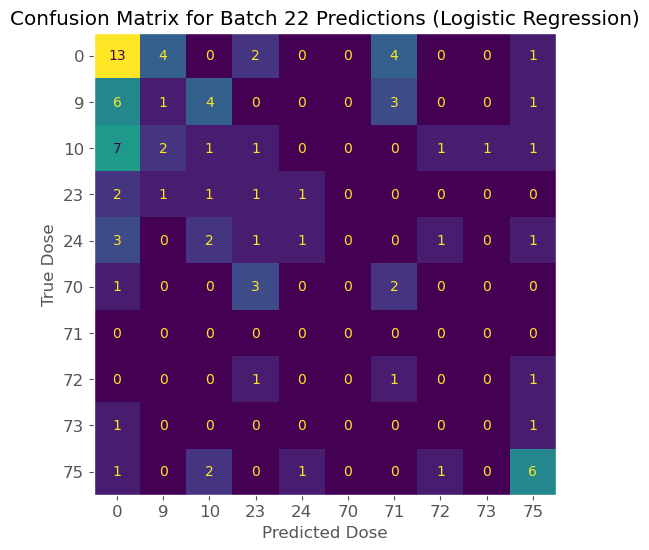

Confusion Matrix:
[[13  4  0  2  0  0  4  0  0  1]
 [ 6  1  4  0  0  0  3  0  0  1]
 [ 7  2  1  1  0  0  0  1  1  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 3  0  2  1  1  0  0  1  0  1]
 [ 1  0  0  3  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  0  0  1]
 [ 1  0  0  0  0  0  0  0  0  1]
 [ 1  0  2  0  1  0  0  1  0  6]]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Select training batches
train_mask = [b in [17, 23, 22] for b in trex_batch]
X_train = X[train_mask][:, idxs]
y_train = rad[train_mask]

# Select testing batch
test_mask = [b == 19 for b in trex_batch]
X_test = X[test_mask][:, idxs]
y_test = rad[test_mask]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model with Elastic Net regularization
log_reg = LogisticRegression(
    random_state=1966, 
    max_iter=500000, 
    solver='saga',  # Required for Elastic Net
    penalty='elasticnet', 
    l1_ratio=1,
    C=0.5
)
log_reg.fit(X_train_scaled, y_train)

# Predict on batch 22
y_pred = log_reg.predict(X_test_scaled)

# Generate and display the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)
ax.grid(False)  # Remove grid lines
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Predicted Dose")
ax.set_ylabel("True Dose")
ax.set_title("Confusion Matrix for Batch 22 Predictions (Logistic Regression)")
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


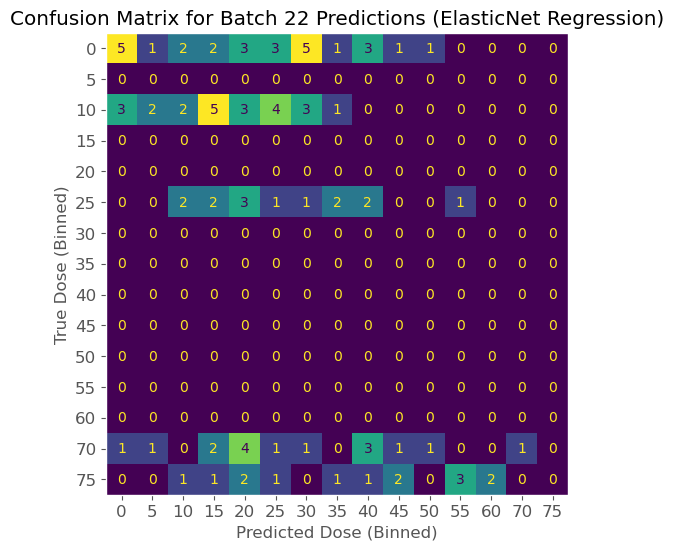

Confusion Matrix:
[[5 1 2 2 3 3 5 1 3 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 2 2 5 3 4 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 3 1 1 2 2 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 2 4 1 1 0 3 1 1 0 0 1 0]
 [0 0 1 1 2 1 0 1 1 2 0 3 2 0 0]]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# Select training batches
train_mask = [b in [17, 19, 23] for b in trex_batch]
X_train = X[train_mask][:, idxs]
y_train = rad[train_mask]

# Select testing batch
test_mask = [b == 22 for b in trex_batch]
X_test = X[test_mask][:, idxs]
y_test = rad[test_mask]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train ElasticNet regression model
elastic_net = ElasticNet(random_state=1966, max_iter=500000, alpha=1, l1_ratio=0.99)
elastic_net.fit(X_train_scaled, y_train)

# Predict on batch 22
y_pred = elastic_net.predict(X_test_scaled)

# Clip predicted doses at 0
y_pred = np.clip(y_pred, 0, None)

# Bin the predictions and true values into categories for confusion matrix
def bin_values(values, bin_size=5):
    return (np.round(values / bin_size) * bin_size).astype(int)

y_pred_binned = bin_values(y_pred)
y_test_binned = bin_values(y_test)

# Generate and display the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test_binned, y_pred_binned, ax=ax, colorbar=False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Predicted Dose (Binned)")
ax.set_ylabel("True Dose (Binned)")
ax.set_title("Confusion Matrix for Batch 22 Predictions (ElasticNet Regression)")
ax.grid(False)  # Remove grid lines
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(confusion_matrix(y_test_binned, y_pred_binned))

[True, True, True, False, False, False, True, True, True, True, True, False, True, True, False, True, False, True, True, True, False, False, False, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, False, True, False, True, True, True, False, False, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, False, True, False, True, True, True, False, False, True, False, True, False, False, True, True, False, True, True, True, True, False, False, True, True, True, True, True, False, True, False, False, True, True, True, True, False, False, True, True, True, True, True, True, False, False, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, False, True, 

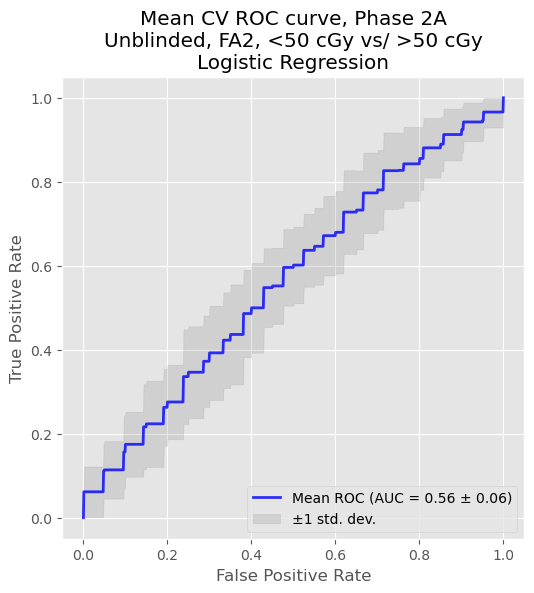

Average Train Accuracy: 70.76% ± 0.78%
Average Test Accuracy: 69.20% ± 1.81%


In [21]:
# Create a combined mask for both conditions
mask = [(f == 'FA2') for r, t, f, s in zip(rad, rates, fa, sample_type)]

# Apply the mask to your arrays
X_targets = X[mask][:,idxs]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add radiation date as a feature:
rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
rad_date_encoded = encoder.fit_transform(rad_date_filtered)
X_targets = np.hstack((X_targets, rad_date_encoded))

y = rad[mask]
y = [r < 50 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .1,
    'penalty': 'elasticnet',
    'l1_ratio': 0.75,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA2, <50 cGy vs/ >50 cGy\nLogistic Regression"
)


['low' 'nan' 'nan' 'nan' 'nan' 'nan' 'high' 'high' 'low' 'high' 'low'
 'nan' 'nan' 'nan' 'nan' 'high' 'nan' 'nan' 'low' 'nan' 'low' 'nan' 'high'
 'nan' 'nan' 'nan' 'nan' 'low' 'nan' 'low' 'nan' 'low' 'high' 'nan' 'low'
 'nan' 'high' 'low' 'nan' 'nan' 'nan' 'low' 'nan' 'low' 'nan' 'nan' 'high'
 'low' 'low' 'nan' 'nan' 'nan' 'low' 'nan' 'nan' 'high' 'high' 'nan' 'low'
 'high' 'nan' 'nan' 'nan' 'low' 'low' 'nan' 'nan' 'nan' 'high' 'nan' 'nan'
 'low' 'low' 'nan' 'nan' 'nan' 'nan' 'nan' 'nan' 'high' 'nan' 'nan' 'low'
 'low' 'nan' 'high' 'nan' 'nan' 'nan' 'high' 'low' 'low' 'high' 'nan'
 'high' 'low' 'low' 'nan' 'low' 'high' 'high' 'high' 'low' 'nan' 'nan'
 'nan' 'nan' 'low' 'nan' 'nan' 'high' 'low' 'high' 'nan' 'high' 'nan'
 'nan' 'high' 'nan' 'high' 'nan' 'low' 'high' 'low' 'nan' 'low' 'nan'
 'nan' 'high' 'high' 'nan' 'high' 'nan' 'nan' 'nan' 'nan' 'low' 'high'
 'low' 'nan' 'low' 'low' 'high' 'nan' 'nan' 'high' 'low' 'nan' 'high'
 'high' 'high' 'low' 'low' 'nan' 'nan' 'nan' 'nan' 'low' 'na

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: False

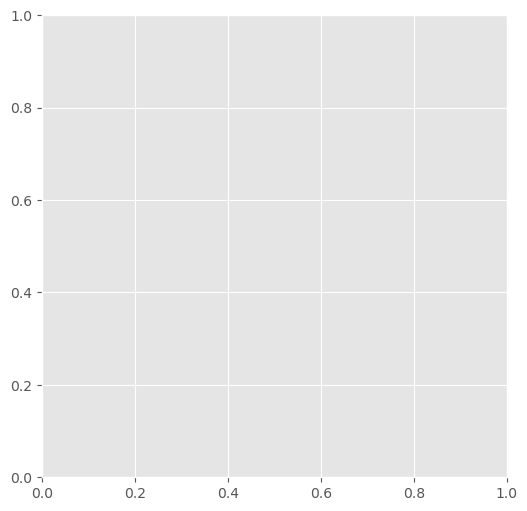

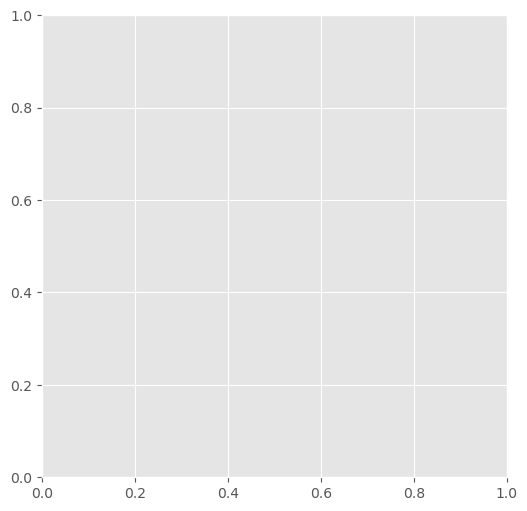

In [25]:
# Create a combined mask for both conditions
mask = [(f == 'FA1' and b in [17, 19, 22, 23]) for r, t, f, s, b, tse in zip(rad, rates, fa, sample_type, trex_batch, time_since_exposure)]

# Apply the mask to your arrays
X_targets = X[mask][:,idxs]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add radiation date as a feature:
rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
rad_date_encoded = encoder.fit_transform(rad_date_filtered)
X_targets = np.hstack((X_targets, rad_date_encoded))

y = rates[mask]
print(y)
y = [r == "LDR" for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .1,
    'penalty': 'elasticnet',
    'l1_ratio': 0.75,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA1, Dose Rate Classifier (All Doses)\nLogistic Regression"
)


[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
(104, 388) 104 0
Baseline Accuracy: 0.0


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: False

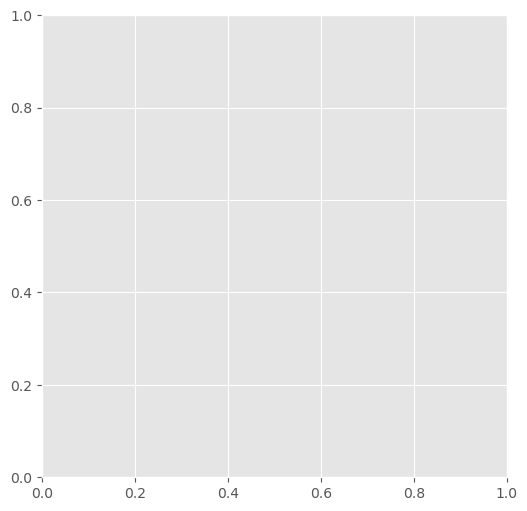

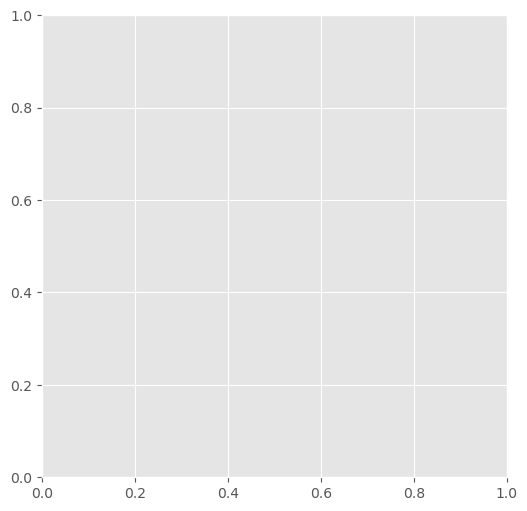

In [22]:
# Create a combined mask for both conditions
mask = [(f == 'FA1' and r > 50) for r, t, f, s in zip(rad, rates, fa, sample_type)]

# Apply the mask to your arrays
X_targets = X[mask][:,idxs]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add interaction terms with batch
original_features = X[mask][:, idxs]  # Only features from X[mask]
interaction_terms = original_features[:, :, None] * batch_encoded[:, None, :]  # Outer product
interaction_terms = interaction_terms.reshape(X_targets.shape[0], -1)
X_targets = np.hstack((X_targets, interaction_terms))

# add radiation date as a feature:
rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
rad_date_encoded = encoder.fit_transform(rad_date_filtered)
X_targets = np.hstack((X_targets, rad_date_encoded))

y = rates[mask]
y = [r == "LDR" for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .1,
    'penalty': 'elasticnet',
    'l1_ratio': 0.75,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA1, Dose Rate Classifier (Dose > 50 cGy)\nLogistic Regression"
)

[ 0 75 65 45 25 15  5  5 65 45 15  5  5 75 55 55  0 75 55 55 75 55 15 15
  0 75 75 65 45 25 75 25  0  0 35 25 65 65 35  5  0  0  0 55 35 35 75 45
  0 45 25 15  5 75 55  5  0  0 75 35 75 65 35 25 75 45 15  5 65 45 45 25
  0 65 55 25 15 35 35 15]
[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, True, True, False, False, False, False, False, True, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False]
(80, 89) 80 12
Baseline Accuracy: 0.15


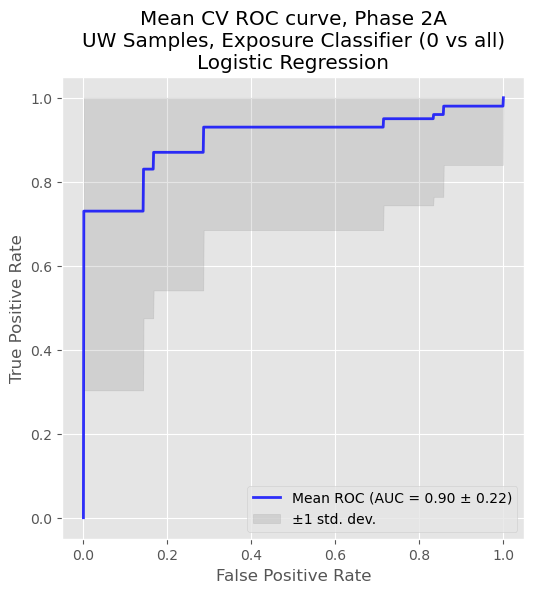

Average Train Accuracy: 100.00% ± 0.00%
Average Test Accuracy: 90.00% ± 7.91%


In [50]:
# Create a combined mask for both conditions
mask = [(s == 'UW Skin Punch') for r, t, f, s in zip(rad, rates, fa, sample_type)]

# Apply the mask to your arrays
X_targets = X[mask][:,idxs]

# # add plate as a feature:
# plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
# plate_encoded = encoder.fit_transform(plate_filtered)
# X_targets = np.hstack((X_targets, plate_encoded))

y = rad[mask]

print(y)
y = [r == 0 for r in y]
print(y)
print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': 5,
    'penalty': 'elasticnet',
    'l1_ratio': 1,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUW Samples, Exposure Classifier (0 vs all)\nLogistic Regression"
)


In [51]:
protein_coef_dict = {name: coef for name, coef in zip(sorted_names, coef_sums)}

# Sort by the absolute value of the coefficient sums
sorted_proteins = sorted(protein_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top 10 most important proteins
for name, coef_sum in sorted_proteins[:1000]:
    print(f"{name}: {coef_sum:.4f}")

sp|Q9D7Q1|CHIT1_MOUSE: -100.5853
sp|Q99K85|SERC_MOUSE: -81.9728
sp|P04441|HG2A_MOUSE: 74.8234
sp|Q6PD03|2A5A_MOUSE: 65.2909
sp|Q8BH86|GLUCM_MOUSE: -62.2616
sp|Q99JF5|MVD1_MOUSE: 56.5446
sp|O89053|COR1A_MOUSE: 53.7163
sp|Q05144|RAC2_MOUSE: -52.8793
sp|Q9D379|HYEP_MOUSE: -48.2370
sp|E9Q2M9|WDFY4_MOUSE: 47.1581
sp|A1L314|MPEG1_MOUSE: -43.8124
sp|Q9CQX2|CYB5B_MOUSE: 38.9551
sp|Q9Z2A9|GGT5_MOUSE: -15.4875
sp|Q9DBS1|TMM43_MOUSE: -15.4708
sp|Q9D3P8|PLRKT_MOUSE: -11.4037
sp|Q8R3I2|MBOA2_MOUSE: -11.1661
sp|Q9D7X8|GGCT_MOUSE: 10.0158
sp|P09581|CSF1R_MOUSE: 8.0864
sp|P17427|AP2A2_MOUSE: -6.9131
sp|Q9D7V9|NAAA_MOUSE: 6.7261
sp|Q8BPU7|ELMO1_MOUSE: 6.6749
sp|Q9WV95|PHLA3_MOUSE: -6.4651
sp|P30355|AL5AP_MOUSE: 5.4920
sp|Q5SUA5|MYO1G_MOUSE: 5.4068
sp|P10810|CD14_MOUSE: 5.1904
sp|Q921M7|CYRIB_MOUSE: -4.9945
sp|P50429|ARSB_MOUSE: 4.9165
sp|Q9CWK8|SNX2_MOUSE: -4.5867
sp|Q60714|S27A1_MOUSE: -4.3318
sp|Q61753|SERA_MOUSE: 3.9496
sp|P01921|HB2D_MOUSE: 3.9116
sp|Q80TY0|FNBP1_MOUSE: 3.8428
sp|Q9D7P9|SPB12_MOUSE

In [49]:
from scipy import stats

def add_noise_features(X, feature_labels=None):
    """
    Add features that capture measurement noise characteristics.
    
    Parameters:
    -----------
    X : numpy.ndarray
        2D array where rows are samples and columns are features
    feature_labels : array-like or None, optional
        List of string labels for the original features
    
    Returns:
    --------
    tuple
        (numpy.ndarray, list) containing:
        - Array with original and new noise-related features
        - List of feature labels including new noise feature labels
        
    Notes:
    ------
    The function adds the following new features:
    - Overall standard deviation (1 feature)
    - Overall IQR (1 feature)
    - Outlier count (1 feature)
    - Overall peak-to-peak range (1 feature)
    - Mean absolute z-score (1 feature)
    - Overall entropy (1 feature)
    - Sample skewness (1 feature)
    - Sample kurtosis (1 feature)
    - Dynamic range ratio (90th/10th percentile) (1 feature)
    Total new features = 9
    """
    n_samples, n_features = X.shape
    new_features = []
    
    # Convert feature_labels to list if it's numpy array or other sequence
    if feature_labels is None:
        feature_labels = [f"feature_{i}" for i in range(n_features)]
    feature_labels = list(feature_labels)
    
    # 1. Standard deviation of each sample
    sample_std = np.std(X, axis=1, keepdims=True)
    new_features.append(sample_std)
    
    # 2. Inter-quartile range of each sample
    sample_iqr = stats.iqr(X, axis=1, keepdims=True)
    new_features.append(sample_iqr)
    
    # 3. Number of outliers in each sample (using Z-score)
    z_scores = stats.zscore(X, axis=0)  # Calculate z-scores across samples for each feature
    outlier_counts = np.sum(np.abs(z_scores) > 2, axis=1, keepdims=True)
    new_features.append(outlier_counts)
    
    # 4. Mean absolute z-score across all features
    mean_abs_zscore = np.mean(np.abs(z_scores), axis=1, keepdims=True)
    new_features.append(mean_abs_zscore)
    
    # 5. Distribution shape features
    sample_skew = stats.skew(X, axis=1).reshape(-1, 1)
    sample_kurt = stats.kurtosis(X, axis=1).reshape(-1, 1)
    new_features.extend([sample_skew, sample_kurt])
    
    # 6. Quantile relationships
    percentile_90 = np.percentile(X, 90, axis=1).reshape(-1, 1)
    percentile_10 = np.percentile(X, 10, axis=1).reshape(-1, 1)
    dynamic_range = percentile_90 / percentile_10
    new_features.append(dynamic_range)
    
    # 5. Peak-to-peak amplitude
    peak_to_peak = np.max(X, axis=1, keepdims=True) - np.min(X, axis=1, keepdims=True)
    new_features.append(peak_to_peak)
    
    # 6. Entropy of the distribution
    def sample_entropy(x):
        hist, _ = np.histogram(x, bins='auto', density=True)
        hist = hist[hist > 0]  # Remove zero probabilities
        return -np.sum(hist * np.log2(hist))
    
    entropy = np.array([sample_entropy(x) for x in X]).reshape(-1, 1)
    new_features.append(entropy)
    
    # Combine original and new features
    X_augmented = np.hstack([X] + new_features)
    
    # Generate labels for new features
    new_labels = [
        "sample_std",
        "sample_iqr",
        "outlier_count",
        "mean_abs_zscore",
        "skewness",
        "kurtosis",
        "dynamic_range",
        "peak_to_peak",
        "entropy"
    ]
    
    # Verify dimensions match
    if len(new_labels) != len(new_features):
        raise ValueError(f"Mismatch in feature dimensions. Generated {len(new_labels)} labels "
                       f"but got {len(new_features)} new features.")
    
    # Combine original and new feature labels
    all_feature_labels = feature_labels + new_labels
    
    return X_augmented, all_feature_labels


[True, True, False, False, True, False, True, False, True, True, True, True, False, False, False, False, True, False, False, True, True, False, True, False, False, False, False, True, True, True, False, False, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, False, False, False, True, True, False, True, False, False, True, False, True, False, False, True, False, True, False, True, False, False, True, False, True, True, True, False]
(74, 395) 74 36
Baseline Accuracy: 0.4864864864864865


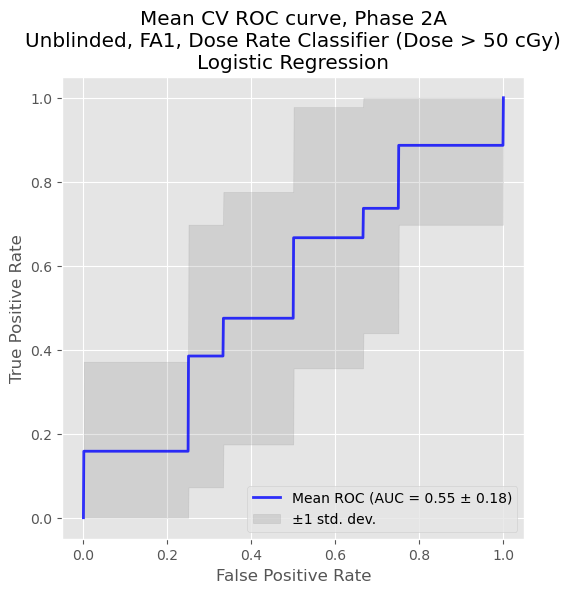

Average Train Accuracy: 63.40% ± 2.94%
Average Test Accuracy: 50.54% ± 16.35%


In [19]:
# Create a combined mask for both conditions
mask = [(f == 'FA1' and r > 50) for r, t, f, s in zip(rad, rates, fa, sample_type)]

# get the data we care about
X_targets = X[mask]

# augment with sample-wide noise-related features 
X_targets, aug_sorted_names = add_noise_features(X_targets, sorted_names)

# limit to features of interest, ensure noise-related features are included
global_feature_idxs = np.arange(X_targets.shape[1])[-9:]
X_targets = X_targets[:, np.concatenate([idxs, global_feature_idxs])]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add interaction terms with batch
original_features = X[mask][:, idxs]  # Only features from X[mask]
interaction_terms = original_features[:, :, None] * batch_encoded[:, None, :]  # Outer product
interaction_terms = interaction_terms.reshape(X_targets.shape[0], -1)
X_targets = np.hstack((X_targets, interaction_terms))

# add radiation date as a feature:
rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
rad_date_encoded = encoder.fit_transform(rad_date_filtered)
X_targets = np.hstack((X_targets, rad_date_encoded))

y = rates[mask]

# print(y)
y = [r == "LDR" for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .1,
    'penalty': 'elasticnet',
    'l1_ratio': 0.75,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA1, Dose Rate Classifier (Dose > 50 cGy)\nLogistic Regression"
)

In [20]:
# protein_coef_dict = {name: coef for name, coef in zip(aug_sorted_names, coef_sums)}

# # Sort by the absolute value of the coefficient sums
# sorted_proteins = sorted(protein_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# # Print the top 10 most important proteins
# for name, coef_sum in sorted_proteins[:1000]:
#     print(f"{name}: {coef_sum:.4f}")

[False, True, False, True, False, False, False, True, False, True, True, False, True, False, False, False, True, True, False, False, True, False, True, True, False, True, False, False, False, True, True, True, True, True, False, True, False, False, True, True, True, False, True, False, False, True, True, True, False, False, False, True, True, True, True, False, True, False, True, False, False, True, False, False, False, True, False, True, True, False, False, False, False, True]
(74, 215) 74 36
Baseline Accuracy: 0.4864864864864865


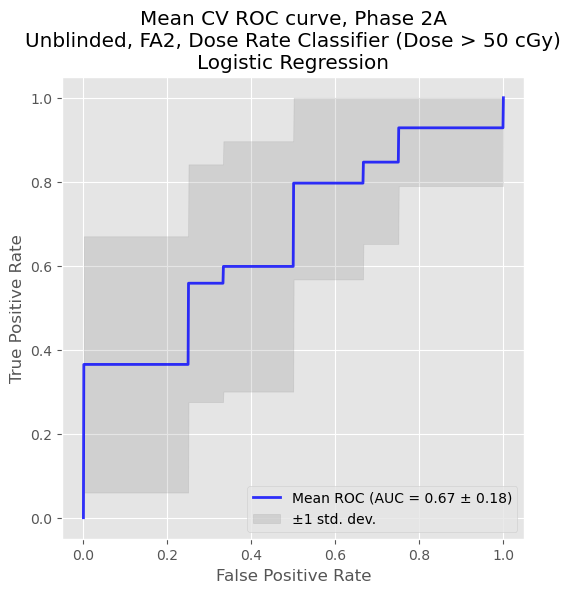

Average Train Accuracy: 75.71% ± 3.45%
Average Test Accuracy: 63.14% ± 16.42%


In [21]:
# Create a combined mask for both conditions
mask = [(f == 'FA2' and r > 50) for r, t, f, s in zip(rad, rates, fa, sample_type)]

# get the data we care about
X_targets = X[mask]

# augment with sample-wide noise-related features 
X_targets, aug_sorted_names = add_noise_features(X_targets, sorted_names)

# limit to features of interest, ensure noise-related features are included
global_feature_idxs = np.arange(X_targets.shape[1])[-9:]
X_targets = X_targets[:, np.concatenate([idxs, global_feature_idxs])]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add interaction terms with batch
original_features = X[mask][:, idxs]  # Only features from X[mask]
interaction_terms = original_features[:, :, None] * batch_encoded[:, None, :]  # Outer product
interaction_terms = interaction_terms.reshape(X_targets.shape[0], -1)
X_targets = np.hstack((X_targets, interaction_terms))

# add radiation date as a feature:
rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
rad_date_encoded = encoder.fit_transform(rad_date_filtered)
X_targets = np.hstack((X_targets, rad_date_encoded))

y = rates[mask]

# print(y)
y = [r == "LDR" for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .1,
    'penalty': 'elasticnet',
    'l1_ratio': 0.75,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA2, Dose Rate Classifier (Dose > 50 cGy)\nLogistic Regression"
)

In [22]:
# protein_coef_dict = {name: coef for name, coef in zip(aug_sorted_names, coef_sums)}

# # Sort by the absolute value of the coefficient sums
# sorted_proteins = sorted(protein_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# # Print the top 10 most important proteins
# for name, coef_sum in sorted_proteins[:1000]:
#     print(f"{name}: {coef_sum:.4f}")

[ 70   0  75   0   0   0   9   9  73  23  70  75  75   0   0  73   0   0
  23  75   9  10  70  75   0  10   0   9  10   9   0  23  24  75  73  75
   9   9  75  10   0   9   0  24   0 100  24   9  71   0   0   0   9  75
  10  71  70   0  23   9  10   0   0  73  23  10  10   0   9   0  10  70
   9  75   0   0 100  75  10  24  75   0   9   9   0  72   0   0  75  23
  71  24  23  75   9  70   9  75  24   9   9  24  72  75  10   0  75  23
   0  10   9  23  71  10  23 100  10  70   0  73   0   9  72   9  75  71
   0   0  23  23   0  23  75  10   0   0  23  72   9  10   9   9   9   0
   0  23  23  10   9   9  72   9  24  10   0  10  75  72   0  24  24   0
  24 100  23  75  23  71  23  72   0  71   0  10   0   0  23  10  10   0
  75   0   9  75   0  23   0   9  70  75   0   0  71  10   9  73  24  10
   9   0   0   9  75 100  71  10   9  72  10  23   0  10  70  70   0  24
   0  75   0   9   9   9  23  24   0  71  75   0   0   0 100   0   0  23
  10   9  10  72   0  10  73   9  75   9   0  72  2

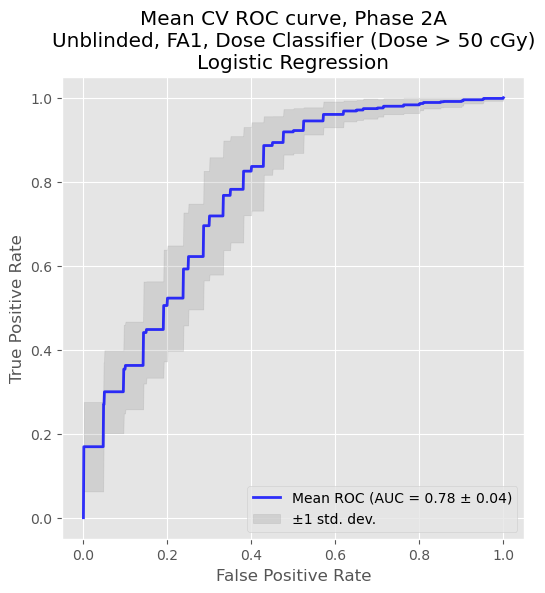

Average Train Accuracy: 82.26% ± 1.04%
Average Test Accuracy: 79.49% ± 2.65%


In [50]:
# Create a combined mask for both conditions
mask = [(f == 'FA1' and r >= 0) for r, t, f, s in zip(rad, rates, fa, sample_type)]

# get the data we care about
X_targets = X[mask]

# augment with sample-wide noise-related features 
X_targets, aug_sorted_names = add_noise_features(X_targets, sorted_names)

# limit to features of interest, ensure noise-related features are included
global_feature_idxs = np.arange(X_targets.shape[1])[-9:]
X_targets = X_targets[:, np.concatenate([idxs, global_feature_idxs])]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add radiation date as a feature:
rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
rad_date_encoded = encoder.fit_transform(rad_date_filtered)
X_targets = np.hstack((X_targets, rad_date_encoded))

y = rad[mask]

print(y)
y = [r < 50 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .1,
    'penalty': 'elasticnet',
    'l1_ratio': 0.75,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA1, Dose Classifier (Dose > 50 cGy)\nLogistic Regression"
)

[True, True, True, False, False, False, True, True, True, True, True, False, True, True, False, True, False, True, True, True, False, False, False, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, False, True, False, True, True, True, False, False, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, False, True, False, True, True, True, False, False, True, False, True, False, False, True, True, False, True, True, True, True, False, False, True, True, True, True, True, False, True, False, False, True, True, True, True, False, False, True, True, True, True, True, True, False, False, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, False, True, 

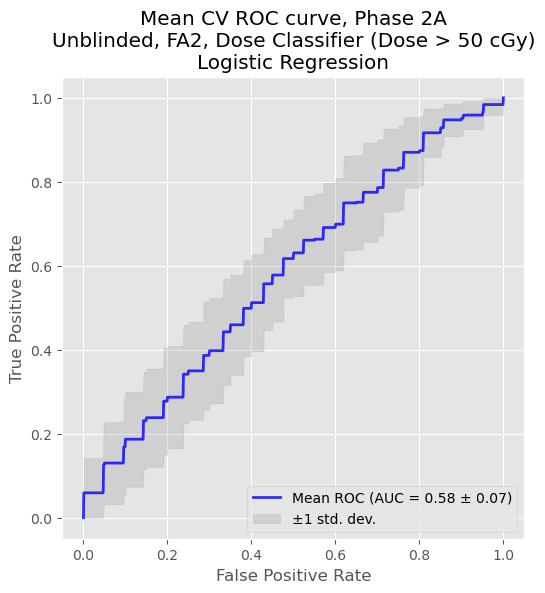

Average Train Accuracy: 70.69% ± 0.61%
Average Test Accuracy: 70.29% ± 0.90%


In [51]:
# Create a combined mask for both conditions
mask = [(f == 'FA2' and r >= 0) for r, t, f, s in zip(rad, rates, fa, sample_type)]

# get the data we care about
X_targets = X[mask]

# augment with sample-wide noise-related features 
X_targets, aug_sorted_names = add_noise_features(X_targets, sorted_names)

# limit to features of interest, ensure noise-related features are included
global_feature_idxs = np.arange(X_targets.shape[1])[-9:]
X_targets = X_targets[:, np.concatenate([idxs, global_feature_idxs])]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add radiation date as a feature:
rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
rad_date_encoded = encoder.fit_transform(rad_date_filtered)
X_targets = np.hstack((X_targets, rad_date_encoded))

y = rad[mask]

# print(y)
y = [r < 50 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': .1,
    'penalty': 'elasticnet',
    'l1_ratio': 1,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA2, Dose Classifier (Dose > 50 cGy)\nLogistic Regression"
)

In [24]:
# protein_coef_dict = {name: coef for name, coef in zip(aug_sorted_names, coef_sums)}

# # Sort by the absolute value of the coefficient sums
# sorted_proteins = sorted(protein_coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# # Print the top 10 most important proteins
# for name, coef_sum in sorted_proteins[:1000]:
#     print(f"{name}: {coef_sum:.4f}")

[False, True, True, True, False, True, True, True, True, True, False, True, True, True, True, False, True, True, False, False, False, True, True, True, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, False, True, True, True, True, False, False, True, True, True, False, False, True, True, True, False, True, False, True, True, False, False, True, False, True, True, False, True, True, True, False, True, False, True, True, False, True, False, True, False, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, True, True, True, True, True]
(139, 388) 139 100
Baseline Accuracy: 0.7194244604316546


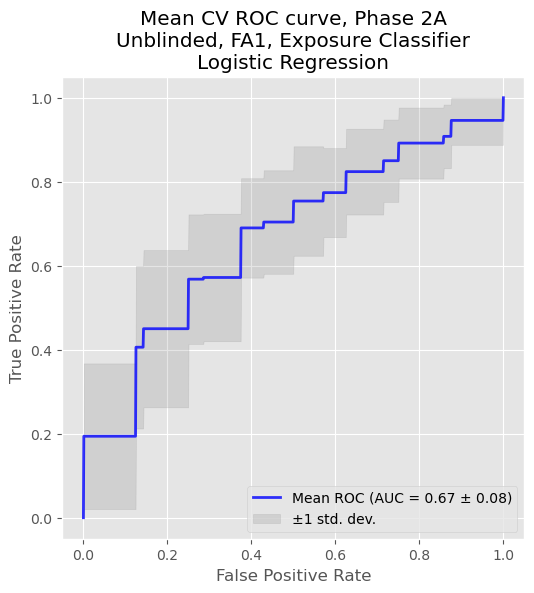

Average Train Accuracy: 71.94% ± 0.26%
Average Test Accuracy: 71.96% ± 1.06%


In [61]:
# Create a combined mask for both conditions
mask = [(f == 'FA1' and r >= 0 and tse in [6,7]) for r, t, f, s, c, tse in zip(rad, rates, fa, sample_type, rad_date, time_since_exposure)]

# get the data we care about
X_targets = X[mask]

# augment with sample-wide noise-related features 
X_targets, aug_sorted_names = add_noise_features(X_targets, sorted_names)

# limit to features of interest, ensure noise-related features are included
global_feature_idxs = np.arange(X_targets.shape[1])[-9:]
X_targets = X_targets[:, np.concatenate([idxs, global_feature_idxs])]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add interaction terms with batch
original_features = X[mask][:, idxs]  # Only features from X[mask]
interaction_terms = original_features[:, :, None] * batch_encoded[:, None, :]  # Outer product
interaction_terms = interaction_terms.reshape(X_targets.shape[0], -1)
X_targets = np.hstack((X_targets, interaction_terms))

# # add radiation date as a feature:
# rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
# rad_date_encoded = encoder.fit_transform(rad_date_filtered)
# print(rad_date_encoded)
# X_targets = np.hstack((X_targets, rad_date_encoded))

y = rad[mask]

# print(y)
y = [r > 0 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': 0.05,
    'penalty': 'elasticnet',
    'l1_ratio': 0.5,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA1, Exposure Classifier\nLogistic Regression"
)

[True, False, False, True, True, True, False, True, True, False, True, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, False, True, True, False, False, True, True, True, True, False, True, False, True, True, True, False, False, True, True, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, False, True, True, False, True, True, True, False, True, True, False, True, True, True, True, False, True, True, False, True, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, False, True, False, False, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, True, False, 

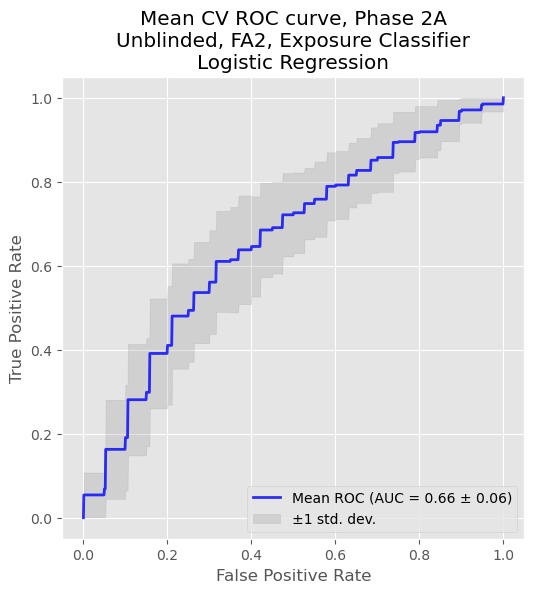

Average Train Accuracy: 72.91% ± 0.49%
Average Test Accuracy: 72.40% ± 0.88%


In [59]:
# Create a combined mask for both conditions
mask = [(f == 'FA2' and r >= 0) for r, t, f, s, c in zip(rad, rates, fa, sample_type, rad_date)]

# get the data we care about
X_targets = X[mask]

# augment with sample-wide noise-related features 
X_targets, aug_sorted_names = add_noise_features(X_targets, sorted_names)

# limit to features of interest, ensure noise-related features are included
global_feature_idxs = np.arange(X_targets.shape[1])[-9:]
X_targets = X_targets[:, np.concatenate([idxs, global_feature_idxs])]

# add plate as a feature:
plate_filtered = plate[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
plate_encoded = encoder.fit_transform(plate_filtered)
X_targets = np.hstack((X_targets, plate_encoded))

# add box number as a feature:
box_filtered = box_number[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
box_encoded = encoder.fit_transform(box_filtered)
X_targets = np.hstack((X_targets, box_encoded))

# add batch as a feature:
batch_filtered = trex_batch[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
batch_encoded = encoder.fit_transform(batch_filtered)
X_targets = np.hstack((X_targets, batch_encoded))

# add interaction terms with batch
original_features = X[mask][:, idxs]  # Only features from X[mask]
interaction_terms = original_features[:, :, None] * batch_encoded[:, None, :]  # Outer product
interaction_terms = interaction_terms.reshape(X_targets.shape[0], -1)
X_targets = np.hstack((X_targets, interaction_terms))

# # add radiation date as a feature:
# rad_date_filtered = rad_date[mask].reshape(-1, 1)  # Reshape for OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
# rad_date_encoded = encoder.fit_transform(rad_date_filtered)
# print(rad_date[mask])
# X_targets = np.hstack((X_targets, rad_date_encoded))

y = rad[mask]

# print(y)
y = [r > 0 for r in y]
print(y)

print(X_targets.shape, len(y), sum(y))

# parameters for Logistic Regression
param = {
    'C': 0.05,
    'penalty': 'elasticnet',
    'l1_ratio': 0.5,
    'max_iter': 100000
}

train_accs, test_accs, coef_sums = crossvalidate_binary_logistic(
    X_targets, 
    y, 
    param, 
    title="Mean CV ROC curve, Phase 2A\nUnblinded, FA2, Exposure Classifier\nLogistic Regression"
)